<a href="https://colab.research.google.com/github/MukundIsGod/SceneDetection/blob/master/Bokeh_Try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from io import BytesIO
import tarfile
import tempfile
import cv2
from six.moves import urllib
from copy import deepcopy
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IMG
import tensorflow as tf

In [1]:
pip install tensorflow==1.15

In [4]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  # INPUT_SIZE = 1024
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')
    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)
  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    print(width, height)
    print("Resize Ratio - {}".format(resize_ratio))
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    print(target_size)
    # target_size = (width, height)
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
      A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
      for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
      ind >>= 3

    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
      label: A 2D array with integer type, storing the segmentation label.

    Returns:
      result: A 2D array with floating type. The element of the array
        is the color indexed by the corresponding element in the input label
        to the PASCAL color map.

    Raises:
      ValueError: If label is not of rank 2 or its value is larger than color
        map maximum entry.
    """
    if label.ndim != 2:
      raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
      raise ValueError('label value too large.')

    return colormap[label]

def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)



In [5]:
# Downloading the mobilenetv2 model form tensorflow site.
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [6]:
# Creating a function which will call the method run from previously define class.
def run_visualization():
  """Inferences DeepLab model and visualizes result."""
  try:
    original_im = Image.open(IMAGE_NAME)
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image')
  resized_im, seg_map = MODEL.run(original_im)
  vis_segmentation(resized_im, seg_map)
  return resized_im, seg_map

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


running deeplab on image
100 100
Resize Ratio - 5.13
(513, 513)


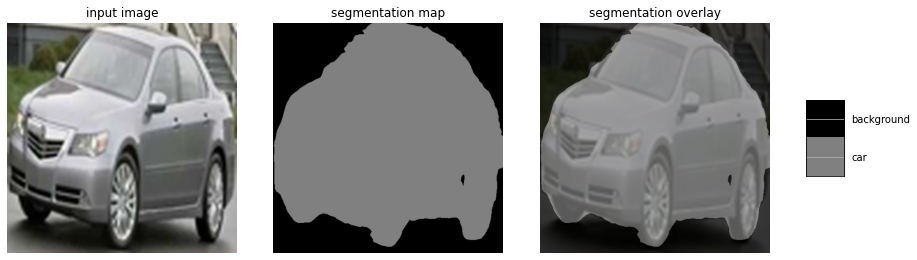

In [11]:
IMAGE_NAME = '/content/drive/My Drive/scenes/seg_train/seg_train/car/car_0002.jpg' # Passing any image.
resized_im, seg_map = run_visualization() 

In [13]:
print(type(resized_im))
numpy_image = np.array(resized_im)

<class 'PIL.Image.Image'>


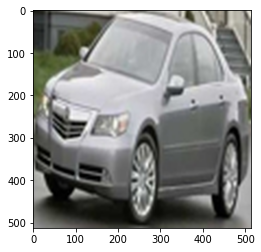

In [14]:
plt.imshow(numpy_image) # Checking the image.

In [15]:
person_not_person_mapping = deepcopy(numpy_image)  # Seperating background & foreground classes using Segmap.
person_not_person_mapping[seg_map != 7] = 0        # Replacing the pixel intensity values to 0 where the car class is not found in segmentation map  i.e changing background to balck.
person_not_person_mapping[seg_map == 7] = 255      

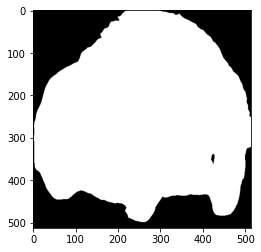

In [16]:
plt.imshow(person_not_person_mapping)

In [18]:
np.unique(person_not_person_mapping)

array([  0, 255], dtype=uint8)

In [19]:
orig_imginal = Image.open(IMAGE_NAME) # Reading the original image.
orig_imginal = np.array(orig_imginal)

In [20]:
mapping_resized = cv2.resize(person_not_person_mapping, # Resizing the mapped image to the original image size.
                             (orig_imginal.shape[1],
                              orig_imginal.shape[0]),
                             Image.ANTIALIAS)

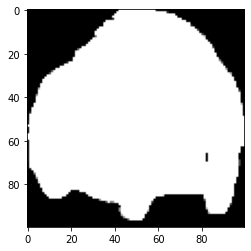

In [21]:
plt.imshow(mapping_resized)

In [22]:
np.unique(mapping_resized)

array([  0,   5,   9,  12,  16,  17,  22,  34,  46,  47,  48,  49,  50,
        62,  66,  68,  73,  78,  79,  83,  89,  93,  94,  95, 111, 116,
       126, 133, 134, 144, 149, 158, 159, 167, 180, 182, 184, 185, 198,
       200, 226, 231, 236, 247, 249, 253, 255], dtype=uint8)

In [23]:
gray = cv2.cvtColor(mapping_resized, cv2.COLOR_BGR2GRAY) # Converting mapped image to gary.
blurred = cv2.GaussianBlur(gray,(15,15),0) # Applying the gaussin blur effect.
ret3,thresholded_img = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

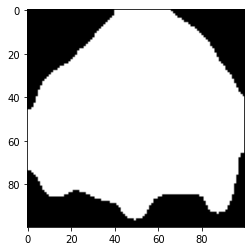

In [24]:
plt.imshow(thresholded_img, cmap="gray")

In [25]:
thresholded_img.ndim

2

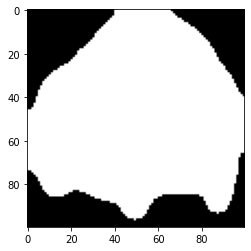

In [26]:
mapping = cv2.cvtColor(thresholded_img, cv2.COLOR_GRAY2RGB) # Applying or converting the throshold image to RGB space.
plt.imshow(mapping)

In [27]:
np.unique(mapping)

array([  0, 255], dtype=uint8)

In [28]:
blurred_original_image = cv2.GaussianBlur(orig_imginal, 
                                          (251,251), 
                                          0)

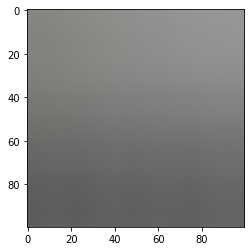

In [29]:
plt.imshow(blurred_original_image)

In [30]:
layered_image = np.where(mapping != (0,0,0), 
                         orig_imginal, 
                         blurred_original_image)

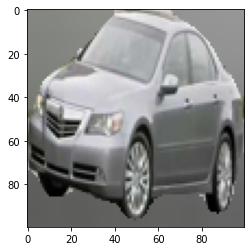

In [31]:
plt.imshow(layered_image) 

In [32]:
im_rgb = cv2.cvtColor(layered_image, cv2.COLOR_BGR2RGB) # Saving the new bokeh image.
cv2.imwrite("Potrait_Image.jpg", im_rgb)

True

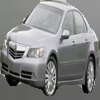

In [33]:
IMG("Potrait_Image.jpg") # Viewing the saved image in orginal size.